# Intro of Machine Learning Project: Style Transfer

 In order to enhance the understanding to deep learning and neural networks, after reading lots of materials and papers, we decieded to choose "Image Style Transfer" as our project. 
 This project A content-image and a style-image. We then wish to create a mixed-image which has the contours of the target-image and the colors and texture of the style-image. We build two loss functions as optimizers:
 
 The loss-function for the content-image is to minimize the difference between the features that are activated for the target-image and for the mixed-image, at layers in the network. This causes the contours of the mixed-image close to those of the target-image.
 
 The loss-function for the style-image is slightly more complicated. It need to minimize the difference between the Gram-matrices for the style-image and the mixed-image. The Gram-matrix is used to measure if the features are activated. So it could take the activated patterns of the style-image as transferred color and texture in mixed-image.
 
 And then we derive the gradient for these loss-functions, which is used to update the mixed-image. Reapeating this method several times, we could finally get a beatiful picture with original content and different styles.
 
 In following project code, we used some codes from others, such as part[5][15][17], and some we made the appropriate changes, such as part[4][13][14][19].
 
 Referrence:
 
 [1]Style-Transfer,https://github.com/VPanjeta/Style-Transfer
 
 [2]How to Do Style Transfer with Tensorflow, Siraj Raval, https://www.youtube.com/watch?v=YoBEGQD3LCc

## Import packages   
Here we use keras running on the tensorflow to import VGG 16, PIL to process images, numpy and scipy for computation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Model
from keras.applications.vgg16 import VGG16
import time
from PIL import Image
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
%matplotlib inline

Using TensorFlow backend.


## Preprocess images
Some of the original images are too large, here we first resize them to the same size, which facilitates the following processing. The target image serves as the base image which will be transfered to anohter style captured from the style image.

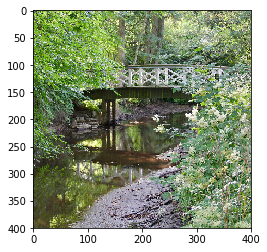

In [2]:
# Set the image size (300,300)
height = 400
width = 400

# Resize the original image
target_img = Image.open(r'C:\Users\Shihao\Documents\FinalProjectForML-master\images\target4.jpg')
target_img = target_img.resize((height,width))
plt.imshow(target_img)

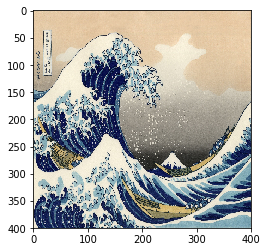

In [3]:
# Same as the target image, the style image 
#also needs to be resized to the same size
style_img = Image.open(r'C:\Users\Shihao\Documents\FinalProjectForML-master\images\style2.jpg')
style_img = style_img.resize((height,width))
plt.imshow(style_img)

Here we convert images to arrays as the input as deep networks.

In [4]:
target_arr = np.asarray(target_img, dtype='float32')
target = np.expand_dims(target_arr, axis=0)
style_arr = np.asarray(style_img, dtype='float32')
style = np.expand_dims(style_arr, axis=0)

According to VGG16 model, we should substract the mean pixel for each channel before input.[citation]

In [5]:
# mean of R component
target[:,:,:,0] -= 103.939 
# mean of G component
target[:,:,:,1] -= 116.779 
# mean of blue component
target[:,:,:,2] -= 123.68  
target = target[:,:,:,::-1] 
# Same processing to style image
style[:,:,:,0] -= 103.939
style[:,:,:,1] -= 116.779
style[:,:,:,2] -= 123.68
style = style[:,:,:,::-1]

## VGG 16 model using imagenet predefined model's weights

In [6]:
# Set the input layer of the VGG 16
target_img = K.variable(target)
style_img = K.variable(style)
mix_img = K.placeholder((1,height,width,3))
input_tensor = K.concatenate([target_img,style_img,\
                                    mix_img], axis=0)

In [7]:
# Generate deep neural networks 
model = VGG16(input_tensor=input_tensor,\
              weights='imagenet', include_top=False)

In [8]:
model.summary()
layer_all = dict([(layer.name, layer.output) for layer in model.layers])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [9]:
# Set the weight for two loss functions
target_w = 1.5
style_w = 5.0
totalvar_w = 1.0

In [10]:
# Initialize the loss value as 0
loss = K.variable(0.)

This function creates a TensorFlow operation for calculating the Mean Squared Error between the two input tensors.

In [11]:
def mse(x,y):
    return K.sum(K.square(x-y))

Here we create the loss function for the target image. Based on the mean square error criterion, the loss of feature activations in the given layers in the model between the target image and the mix image. Minimizing the loss means that the mix image has similar feature activations in the given layers compared to the target image. 

In [12]:
# choose the layer to transfer the contours from the target image 
# to the mix image.
target_features = layer_all['block2_conv2']
# get the target image features
target_val = target_features[0, :, :, :]
# get the mix image features
mix_val = target_features[2, :, :, :]
# count the target loss value
loss += target_w*mse(target_val, mix_val)

Style layers will undergo the similar processing, but here we would like to understand which features in the style-layers activate simultaneously for the style-image, and then copy this activation-pattern to the mixed-image.

It is widely applied that calculating so-called Gram-matrix for the tensors output by the style-layers can present good relations. The Gram-matrix is essentially just a matrix of dot-products for the vectors of the feature activations of a style-layer. If an entry in the Gram-matrix has a value close to zero then it means the two features in the given layer do not activate simultaneously for the given style-image. And vice versa, if an entry in the Gram-matrix has a large value, then it means the two features do activate simultaneously for the given style-image. We will then try and create a mixed-image that replicates this activation pattern of the style-image.

Therefore, we design the gram_matrix function for further usage in the style loss function.

In [13]:
def gram_matrix(x):
#     shape = x.get_shape()
# #     num_channels = int(shape[3])
#     num_channels = 3
#     matrix = K.reshape(x,shape=[-1,num_channels])
#     gram = K.dot(K.transpose(matrix),matrix)
    
#     Reshape the tensor so it is a 2-dim matrix. This essentially
#     flattens the contents of each feature-channel.
    feats = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    
    # Calculate the Gram-matrix as the matrix-product of
    # the 2-dim matrix with itself. This calculates the
    # dot-products of all combinations.
    gram = K.dot(feats, K.transpose(feats))
    
    return gram


## Style Loss
The loss function of style image is quite similar to the loss function of target image but here we are not dealing with the sum of the square error of raw inputs but the one of Gram matrix.

In [14]:
# Create the loss-function for the style-image.
def style_loss(style, mix):
    # calculate the gram matrix of style image and conbination image
    S = gram_matrix(style)
    C = gram_matrix(mix)
    
    # get the number of feature channels
    channels = 3
    
    # get the feature size
    size = height * width
    
    # get the loss of style image by counting sum((s-c)^2/(4 x channels^2 x size^2))
    styleloss = K.sum(K.square(S - C) / (4.*(channels**2)*(size**2)))
    return styleloss

feature_layers = ['block1_conv2', 'block2_conv2','block3_conv3', 'block4_conv3','block5_conv3']
for layer_name in feature_layers:
    # choose the layer to collect the combination features
    layer_features = layer_all[layer_name]
    
    # get the style image features
    style_features = layer_features[1, :, :, :]
    
    # get the mix image features
    mix_features = layer_features[2, :, :, :]
    
    sl = style_loss(style_features, mix_features)
    # add the loss of style iamge into the loss function
    loss += (style_w / len(feature_layers)) * sl

This creates the loss-function for denoising the conbinated-image. The algorithm shifts the image one pixel in the x- and y-axis, calculates the difference from the original image, takes the absolute value to ensure the difference is a positive number,and sums over all the pixels in the image.

In [15]:
def total_variation_loss(x):
    a = K.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = K.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    totalloss = K.sum(K.pow(a + b, 1.25))
    return totalloss


loss += totalvar_w * total_variation_loss(mix_img)

## Loss optimization

In this section, we use gradient descent to find an image that minimizes the loss-functions of the target-layers and style-layers. 
 
This is the weighted loss-function that we will minimize below in order to generate the mixed-image.

In [16]:
# Return the gradient of combinated image variable with respect to loss function
grads = K.gradients(loss, mix_img)

Calculate the gradient of the combined loss-function with regard to the input image, and then define the function to evaluate the value of the gradient and loss function. It adapts the weighting during optimization to ensure the desired ratio between style, target and mixed is preserved

In [17]:
outputs = [loss]
outputs = outputs + grads

#Form a function to run gradient of combination on loss 
f_outputs = K.function([mix_img], outputs)

def eval_loss_and_grads(x):
    #Build a height*width*3 input
    x = x.reshape((1, height, width, 3))
    #Calculate gradient of loss function
    outs = f_outputs([x])
    #Get loss function value
    loss_value = outs[0]
    #Get the gradient value
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):
    #Initialize the loss and gradient values
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
    #Using above function to get the loss value
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    #Using above function to get the gradient value
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

This function is to rebuild the whole image by removing the added 4th channel of image, and then adding the mean component of 3 colors to color channels.

In [18]:
def rebuild_image(xin):
    # Removing the added 4th feature
    x = xin
    x = x.reshape((height, width, 3))    
    # BGR to RGB
    x = x[:, :, ::-1]                    
    # Get mean of each component of RGB
    x[:, :, 0] += 103.939   
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68                 
    x = np.clip(x, 0, 255).astype('uint8')
    image=Image.fromarray(x)
    return image

To show the exactly changes of mixed image in running each epoch, this function plots the target-, mixed- and style-images.

In [19]:
def step_show_image(target_img, style_img, mix_img):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
        
    target_imgre = rebuild_image(target_img)
    mixed_imgre = rebuild_image(mix_img)
    style_imgre = rebuild_image(style_img)

    # Plot the target image.
    ax = axes.flat[0]
    ax.imshow(target_imgre, interpolation='sinc')
    ax.set_xlabel("Target")

    # Plot the mixed mage.
    ax = axes.flat[1]
    ax.imshow(mixed_imgre, interpolation='sinc')
    ax.set_xlabel("Mixed")

    # Plot the style image
    ax = axes.flat[2]
    ax.imshow(style_imgre, interpolation='sinc')
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Starting epoch 0; Current loss value: 3.70981e+11
epoch 0 completed in 183s


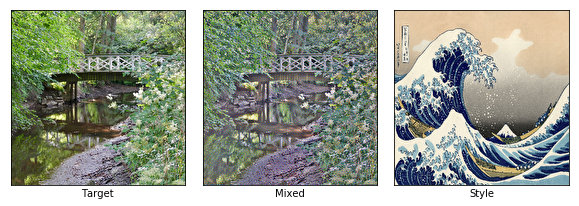

Starting epoch 1; Current loss value: 3.1103e+11
epoch 1 completed in 182s


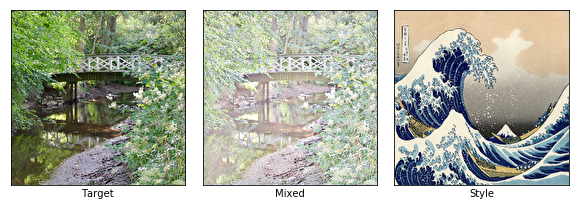

Starting epoch 2; Current loss value: 2.78919e+11
epoch 2 completed in 182s


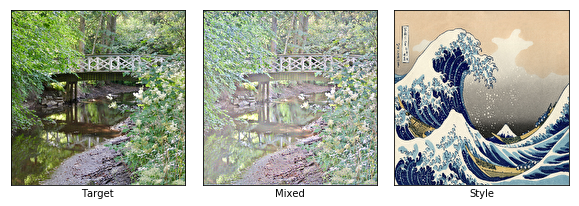

Starting epoch 3; Current loss value: 2.56698e+11
epoch 3 completed in 182s


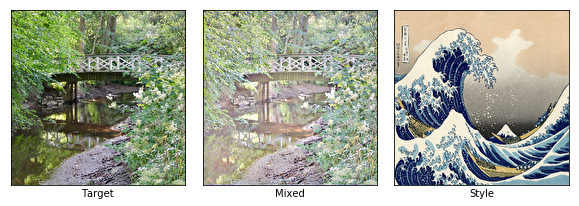

Starting epoch 4; Current loss value: 2.8362e+11
epoch 4 completed in 182s


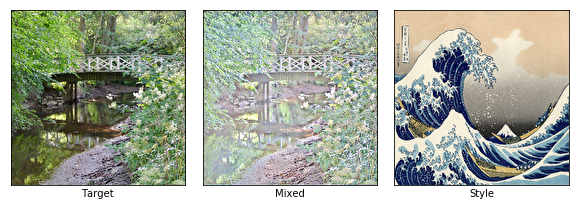

Starting epoch 5; Current loss value: 2.66447e+11
epoch 5 completed in 182s


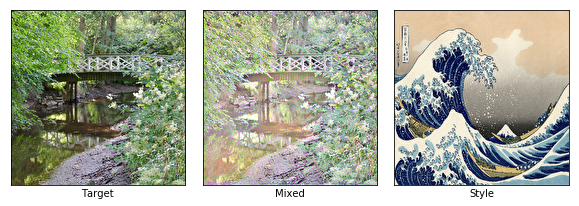

Starting epoch 6; Current loss value: 3.01382e+11
epoch 6 completed in 182s


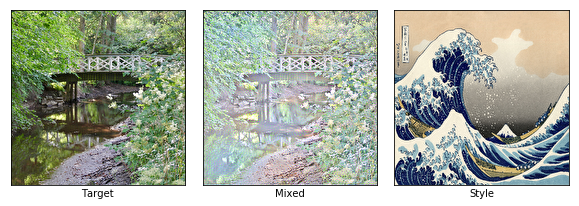

Starting epoch 7; Current loss value: 2.75691e+11
epoch 7 completed in 182s


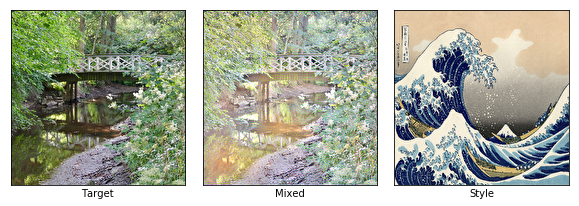

Starting epoch 8; Current loss value: 3.08037e+11
epoch 8 completed in 183s


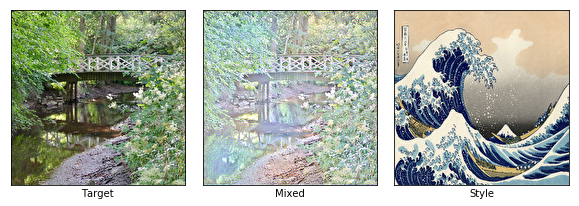

Starting epoch 9; Current loss value: 2.81054e+11
epoch 9 completed in 183s


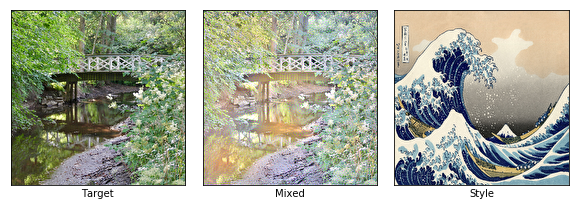

In [20]:
#Initialize the mixed image as a random noise image
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.
#Set the number of epochs 
epochs = 10

#Perform the style-transfer. This automatically creates the appropriate loss-functions for 
#the style- and target-layers, and then performs a number of optimization iterations. 
for i in range(epochs):
    print('Starting epoch', i, end = "; ")
    s_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun = 20)
    print('Current loss value:', min_val)
    f_time = time.time()
    print('epoch %d completed in %ds' % (i, f_time - s_time))
    step_show_image(K.eval(target_img), K.eval(style_img), x)

## Conclusion
This project illustrates the idea of style transfer through deep learning which is pretty popular recently.

Here we adopt VGG-16 pretrained networks and modifies parameters of convolution layers. The results show that portrait is more suitable to be a target image because of their clear edges. However, the program is limited by the computation power and time. We do not choose large images, more iterations or train full connected layers. We believe that the output results will be much better with more iterations. Furthermore, the weight choice is of importance which deserves more deliberate considerations.

To improve the results, we would like to try other optimizers like Adam optimizer and other CNN models like VGG-19. 